* In this kernel we are going to use ImageDataGenerator to load images in batches of 16, and adding augmentation.
* *CROPPING IMAGE* : We will also use image cropping to crop the extra black part in the images in the training data.
* We will use the resnet50 model and then train it exclusively for our train set.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("./input/aptos2019-blindness-detection/"))
from keras.applications import ResNet50, VGG19
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
import csv
import gc
import cv2

['test_images', 'train_new', 'train_images']


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
train_csv = "./input/train.csv"
test_csv = "./input/test.csv"
train_dir = "./input/aptos2019-blindness-detection/train_images/"
test_dir = "./input/aptos2019-blindness-detection/test_images/"
size = 256,256 # input image size

In [3]:
df = pd.read_csv(train_csv)

* The function defined below takes the dataframe of training data as an argument and return two dataframes, one for Training and one for Validation. 
* Need of this function : we are using image data generator with flow_from_dataframe and 10% validation split so if we use same ImageDataGenerator for training and validation data generation it will also augment the validation data, thus we will define seperate dataframes for training and validation data generation.

In [4]:
image_ids = df["id_code"].values.tolist()
labels = df["diagnosis"].values.tolist()

for i in range(len(image_ids)):
    imgname = image_ids[i]
    newname = str(imgname) + ".png"
    image_ids[i] = newname

x_train, x_val, y_train, y_val = train_test_split(image_ids, labels, test_size = 0.25)
df_train = pd.DataFrame({"id_code":x_train, "diagnosis":y_train})
df_val = pd.DataFrame({"id_code":x_val, "diagnosis":y_val})
df_train["diagnosis"] = df_train["diagnosis"].astype('str')
df_val["diagnosis"] = df_val["diagnosis"].astype('str')

print("Length of Training Data :",len(df_train))
print("Length of Validation Data :",len(df_val))

Length of Training Data : 2746
Length of Validation Data : 916


In [5]:
gc.collect()

17

#### CROPPING FUNCTION :

In [6]:
def get_cropped_image(image):
    img = cv2.blur(image,(2,2))
    slice1Copy = np.uint8(img)
    canny = cv2.Canny(slice1Copy, 0, 50)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped_img = img[y1:y2, x1:x2]
    cropped_img = cv2.resize(cropped_img, size)
    cropped_img = cropped_img.astype("float32")*(1.)/255
    return np.array(cropped_img)

Demonstration of above function :


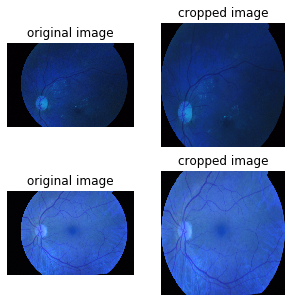

In [7]:
sample_to_show = ['07419eddd6be.png','0124dffecf29.png']

names = []
samples = []
cropped_images = []

for i in sample_to_show:
    path = train_dir + str(i)
    img_ = cv2.imread(path)
    samples.append(img_)
    cropped_ = get_cropped_image(img_)
    cropped_images.append(cropped_)
    
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(2,2,1)
ax1.title.set_text('original image'), ax1.axis("off"), plt.imshow(samples[0])
ax2 = fig.add_subplot(2,2,2)
ax2.title.set_text('cropped image'), ax2.axis("off"), plt.imshow(cropped_images[0])
ax3 = fig.add_subplot(2,2,3)
ax3.title.set_text('original image'), ax3.axis("off"), plt.imshow(samples[1])
ax4 = fig.add_subplot(2,2,4)
ax4.title.set_text('cropped image'), ax4.axis("off"), plt.imshow(cropped_images[1]);

In [8]:
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract

In [9]:
input_1 = Input(shape=(256, 256, 3))
input_2 = Input(shape=(256, 256, 3))

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False)

/home/oscar/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [11]:
for x in base_model.layers[:-3]:
    x.trainable = True

x1 = base_model(input_1)
x2 = base_model(input_2)

#     x1_ = Reshape(target_shape=(7*7, 2048))(x1)
#     x2_ = Reshape(target_shape=(7*7, 2048))(x2)
#     #
#     x_dot = Dot(axes=[2, 2], normalize=True)([x1_, x2_])
#     x_dot = Flatten()(x_dot)

x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

x3 = Subtract()([x1, x2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([x1, x1])
x2_ = Multiply()([x2, x2])
x4 = Subtract()([x1_, x2_])
x = Concatenate(axis=-1)([x4, x3])

x = Dense(100, activation="relu")(x)
x = Dropout(0.01)(x)
out = Dense(5, activation="sigmoid")(x)

model = Model([input_1, input_2], out)


This kernel helped me choose the model parameters, and callbacks - [APTOS Blindness Detection - EDA and Keras ResNet50](https://www.kaggle.com/dimitreoliveira/aptos-blindness-detection-eda-and-keras-resnet50?scriptVersionId=16639594)

In [12]:
optimizer = keras.optimizers.Adam(lr=2e-4)

es = EarlyStopping(monitor='val_loss', mode='min', patience = 8, restore_best_weights=True)
# rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience = 3, factor = 0.5, min_lr=1e-6)
    
# callback_list = [es, rlrop]
callback_list = [es]

model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"]) 

In [13]:
BATCH_SIZE = 32

In [14]:
len(x_train)

2746

You need a generator that yields something of the form **([x1, x2], y)** So you need to write your own generator, for which you can reuse the original ImageDataGenerator for one or more input.

In [15]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=15, 
                        width_shift_range=0.1,
                        height_shift_range=0.1, 
                        horizontal_flip=True,
                        fill_mode="nearest")

In [16]:
# h = model.fit_generator( aug.flow([x_train, x_train],y_train, batch_size = 32),
#                          validation_data = ([y_train, y_train], y_val ),
#                          epochs = 5,
#                          verbose=1,
#                          steps_per_epoch = 2746 // BATCH_SIZE, 
#                          generator = ([train_generator, train_generator]),
#                          callbacks = callback_list)

1

# remember that a network expects a batch size. 
# if you're submitting only one image of shape (244,244,3), you'll need to first np.expand_dims(image, axis=0) 
# to achieve shape (1,244,244,3) prior to prediction. 
# That will be 1 image of 244 by 244 with 3 layers, i.e. (1,244,244,3).

1

In [17]:
# x_train, x_val, y_train, y_val
h = model.fit_generator( aug.flow([x_train, x_train],y_train, batch_size = 32),
                         validation_data = ([y_train, y_train], y_val ),
                         epochs = 5,
                         verbose=1,
                         steps_per_epoch = len(x_train) // BATCH_SIZE, 
                         generator = ([train_generator, train_generator]),
                         callbacks = callback_list)

TypeError: len() of unsized object

TEST:

Processing test dataframe.

In [ ]:
test_df_orig = pd.read_csv(test_csv)

def process_test_df(test_df):
    test_ids = test_df["id_code"].values.tolist()
    for i in range(len(test_ids)):
        imgname = test_ids[i]
        newname = str(imgname) + ".png"
        test_ids[i] = newname
    test_df["id_code"] = test_ids
    return test_df

test_df = process_test_df(test_df_orig)

Test Data Generator :

In [ ]:
test_aug = ImageDataGenerator(rescale = 1./255)

test_generator = test_aug.flow_from_dataframe(dataframe = test_df, 
                                              directory = test_dir,
                                              x_col = "id_code",
                                              batch_size = 1,
                                              target_size = (256,256),
                                              shuffle = False,
                                              class_mode = None)

#### PREDICTION

In [ ]:
predprobs = model.predict_generator(test_generator, steps=len(test_generator))

In [ ]:
predictions = []
for i in predprobs:
    predictions.append(np.argmax(i)) 

In [ ]:
test_df_orig["diagnosis"] = predictions

Submission :

In [ ]:
test_df_orig.to_csv('submission.csv',index=False)